# **Importing Libraries**

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import Sequential

# **Data Discovery**

In [79]:
data=pd.read_csv('train.csv')

In [5]:
data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
data.info()

**Data Separation**

In [269]:
target=data['NObeyesdad']
features=data.drop(['NObeyesdad','id'],axis=1)
cat_features=[]
num_features=[]
for col in features.columns:
  if features[col].dtype == object:
    cat_features.append(col)
  else:
    num_features.append(col)
print('categorical features :',cat_features)
print('numerical features',num_features)


categorical features : ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical features ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


We have to understand each feature meaning :
* FAVC : Consume high-calorie foods frequently
* FCVC :	Number of meals where you usually eat vegetables
* NCP :	Number of main meals a day
* CAEC : Eat food between meals
* CH2O : Liters of water you drink a day
* SCC :	Monitor the calories you consume daily
* FAF :	Frequency of days per week that you often have physical activity
* CALC : Frequency of alcohol intake.
* MTRANS : Means of transportation that you use regularly
* TUE :	Time of use of technological devices on a daily basis

**Plots to gain insights**

we start by the categorical columns

In [ ]:
i=1
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.7)
for feat in cat_features:
  plt.subplot(3,3,i)
  sns.countplot(data=data, x="NObeyesdad", hue=feat)
  plt.xticks(rotation=90)
  i=i+1

plt.show()

*   we see that obesity 3 type are all women
*   family history with obesity is so related to the person type
*   people that highly consume high calory food suffer from overweight
*   people that frequently consume food between meals are more likely to not suffer from obesity
*   smoking have no relation with obesity
*   scc doesn't provide an information
*   people that consume alcohol are the ones that are in danger of obesity unlike people who doesn't
*   people who walk doesn't suffer from obesity




we will see the distribution of numerical columns and the correlation with our targeted column

In [ ]:
plt.figure(figsize=(12,12))
i=1

for c in num_features:
  plt.subplot(3,3,i)
  sns.histplot(data=data, x=c, kde=True)
  i=i+1



# **Outlier Handling**

we will plot to see if there is a lot of outliers for numerical features

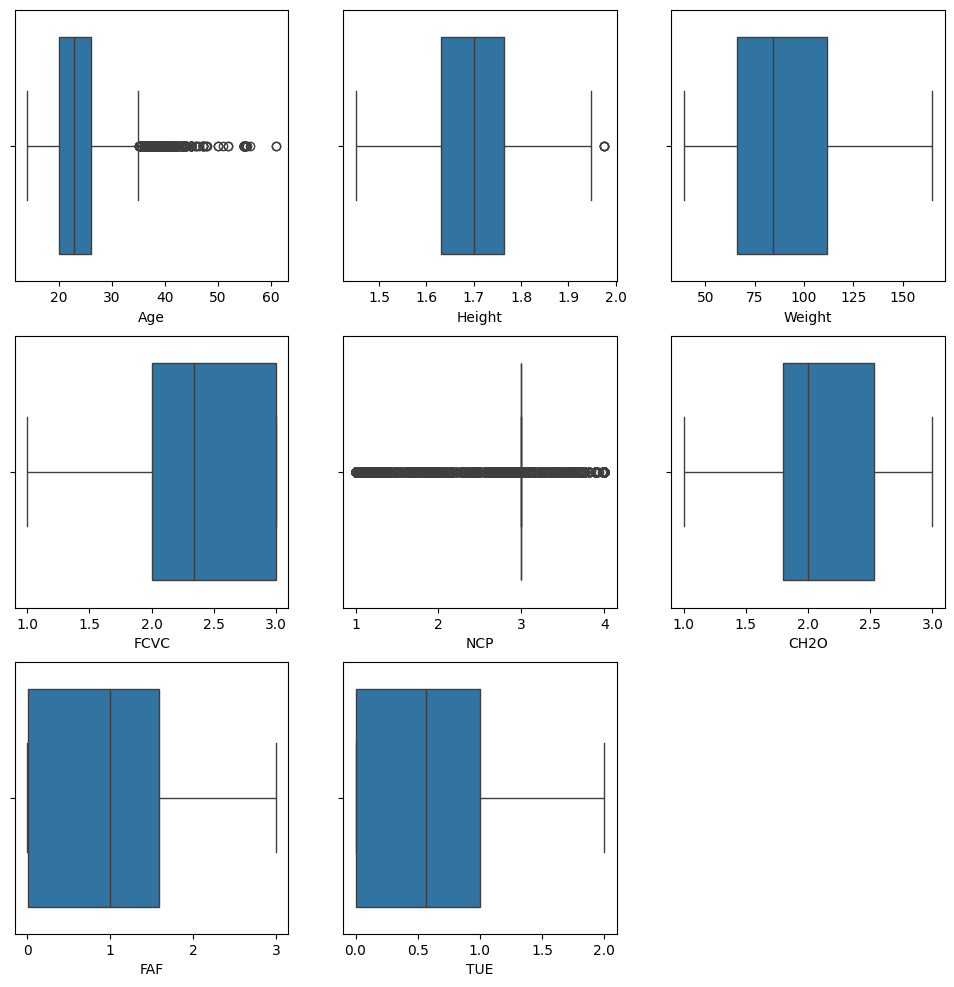

In [18]:
plt.figure(figsize=(12,12))
i=1

for c in num_features:
  plt.subplot(3,3,i)
  sns.boxplot(data=data, x=c)
  i=i+1


In [17]:
def replace_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = data[column].median()

# **Features Engineering**

let's make a new features set and see if it improves accuracy for a random forest classifier

In [270]:
newfeatures=features

In [271]:
newfeatures['bmi']=features['Weight']/features['Height']/features['Height']

In [272]:
le=LabelEncoder()
newfeatures[cat_features] = newfeatures[cat_features].apply(lambda col: le.fit_transform(col))


In [273]:
newfeatures.tail()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,bmi
20753,1,25.137087,1.766626,114.187096,1,1,2.919584,3.000000,2,0,2.151809,0,1.330519,0.196680,1,3,36.587084
20754,1,18.000000,1.710000,50.000000,0,1,3.000000,4.000000,1,0,1.000000,0,2.000000,1.000000,1,3,17.099278
20755,1,20.101026,1.819557,105.580491,1,1,2.407817,3.000000,2,0,2.000000,0,1.158040,1.198439,2,3,31.889841
20756,1,33.852953,1.700000,83.520113,1,1,2.671238,1.971472,2,0,2.144838,0,0.000000,0.973834,2,0,28.899693
20757,1,26.680376,1.816547,118.134898,1,1,3.000000,3.000000,2,0,2.003563,0,0.684487,0.713823,1,3,35.800157


accuracy of random forest was 86%

In [274]:
le=LabelEncoder()
target_=le.fit_transform(target)
target = pd.DataFrame(target_)


In [275]:
newfeatures = newfeatures.drop(newfeatures.index[-1])

In [276]:
target = target.drop(target.index[-1])

In [277]:
mms=MinMaxScaler(feature_range=(0,1))
newfeatures_scaled=mms.fit_transform(newfeatures)
newfeatures = pd.DataFrame(newfeatures_scaled, columns=newfeatures.columns)


# **ML Models**

In [278]:
x_train,x_test,y_train,y_test=train_test_split(newfeatures,target,train_size=0.8,random_state=42)

In [279]:
model=RandomForestClassifier()
model.fit(x_train,y_train)
pred=model.predict(x_test)
print(accuracy_score(y_test,pred))

<ipython-input-279-0304ca30c097>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


0.8945086705202312


In [280]:
model=LGBMClassifier(
n_estimators = 1312,
learning_rate = 0.018279520260162645,
gamma = 0.0024196354156454324,
reg_alpha = 0.9025931173755949,
reg_lambda = 0.06835667255875388,
max_depth = 5,
min_child_weight = 5,
subsample = 0.883274050086088,
colsample_bytree = 0.6579828557036317,
             )
model.fit(x_train,y_train)
pred=model.predict(x_test)
print(accuracy_score(y_test,pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

# **ANN**

In [156]:
ann=Sequential()
ann.add(Dense(units=32, activation='relu',input_shape=(13,)))
ann.add(Dense(units=64, activation='relu'))
ann.add(Dense(units=128, activation='relu'))
ann.add(Dense(units=7, activation='softmax'))
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/200
19/19 [==============================] - 1s 14ms/step - loss: 1.8853 - accuracy: 0.2135 - val_loss: 1.8132 - val_accuracy: 0.2625
Epoch 2/200
19/19 [==============================] - 0s 5ms/step - loss: 1.7082 - accuracy: 0.3256 - val_loss: 1.5622 - val_accuracy: 0.3642
Epoch 3/200
19/19 [==============================] - 0s 5ms/step - loss: 1.4260 - accuracy: 0.4288 - val_loss: 1.2789 - val_accuracy: 0.4846
Epoch 4/200
19/19 [==============================] - 0s 5ms/step - loss: 1.1557 - accuracy: 0.5434 - val_loss: 1.0357 - val_accuracy: 0.6127
Epoch 5/200
19/19 [==============================] - 0s 6ms/step - loss: 0.9419 - accuracy: 0.6443 - val_loss: 0.8543 - val_accuracy: 0.6729
Epoch 6/200
19/19 [==============================] - 0s 5ms/step - loss: 0.7875 - accuracy: 0.7074 - val_loss: 0.7195 - val_accuracy: 0.7346
Epoch 7/200
19/19 [==============================] - 0s 6ms/step - loss: 0.6707 - accuracy: 0.7606 - val_loss: 0.6210 - val_accuracy: 0.7856
Epoch 8/200


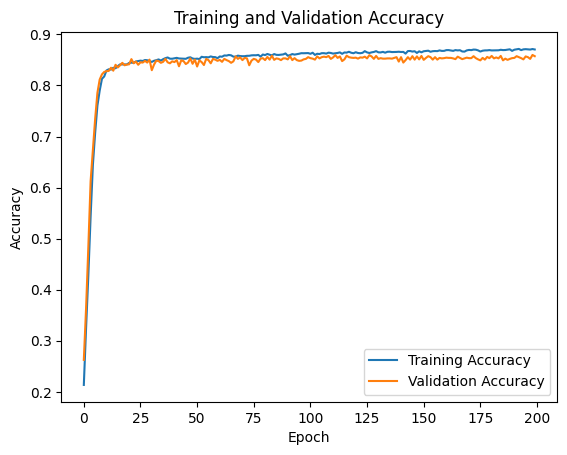

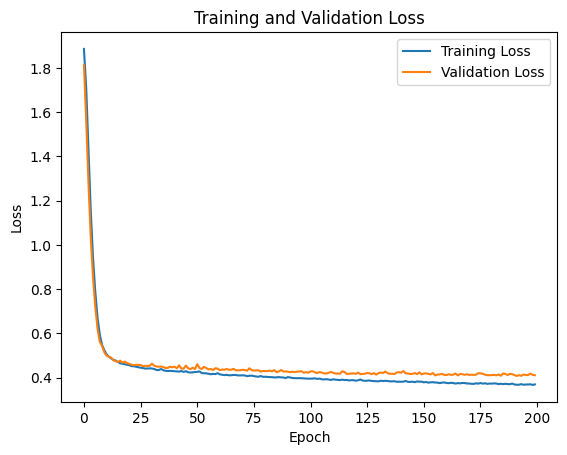

In [157]:
history = ann.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=1000, verbose=1)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()